In [ ]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("csv")

csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"Znaleziono {len(csv_files)} plików CSV:")
for f in csv_files:
    print(" -", f.name)


Znaleziono 9 plików CSV:
 - 20200507 I konkurs I Biblioteki_cleaned.csv
 - 20200507 I konkurs I Popularyzacja_cleaned.csv
 - 20211231 I konkurs II Biblioteki_cleaned.csv
 - 20211231 I konkurs II Popularyzacja_cleaned.csv
 - 20220926 I konkurs III Biblioteki_cleaned.csv
 - 20220926 I konkurs III Popularyzacja_cleaned.csv
 - 20241104 II Biblioteki_cleaned.csv
 - 20241104 II Popularyzacja_cleaned.csv
 - 20241230 II Popularyzacja - lista dodatkowa_cleaned.csv


In [2]:
dfs = []
for file in csv_files:
    df = pd.read_csv(file, dtype=str)
    df["Źródło"] = file.stem
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(f"\nPołączono dane: {len(df_all)} wierszy łącznie.")
df_all.head()



Połączono dane: 830 wierszy łącznie.


,Lp,Numer rejestracyjny,Wnioskodawca,Tytuł projektu,Kwota,Data przyznania,Konkurs,Moduł,Źródło
0,1,SONB/SP/461244/2020,Akademia Muzyczna im. Karola Szymanowskiego w ...,Budowa cyfrowego repozytorium kolekcji afiszy ...,223344,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned
1,2,SONB/SN/469058/2020,Diecezja Sandomierska,"Konserwacja zachowawcza,opracowanie i udostępn...",250000,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned
2,3,SONB/SN/469156/2020,Diecezja Sandomierska,"Konserwacja, opracowanie i udostępnienie 70 st...",224734,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned
3,4,SONB/SP/461397/2020,Katolicki Uniwersytet Lubelski Jana Pawła II,Opracowanie i digitalizacja dawnych unikatowyc...,170280,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned
4,5,SONB/SP/461400/2020,Katolicki Uniwersytet Lubelski Jana Pawła II,Digitalizacja unikatowych periodyków ukraiński...,218460,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned


In [3]:
print("Kolumny w zbiorczym DataFrame:")
print(df_all.columns.tolist())

print("\nLata / Konkursy / Moduły:")
print(df_all["Data przyznania"].unique())
print(df_all["Konkurs"].unique())
print(df_all["Moduł"].unique())


Kolumny w zbiorczym DataFrame:
['Lp', 'Numer rejestracyjny', 'Wnioskodawca', 'Tytuł projektu', 'Kwota', 'Data przyznania', 'Konkurs', 'Moduł', 'Źródło']

Lata / Konkursy / Moduły:
['2020-05-07' '2021-12-31' '2022-09-26' '2024-11-04' '2024-12-30']
['SON I konkurs I' 'SON I konkurs II' 'SON I konkurs III' 'SON II']
['Biblioteki' 'Popularyzacja']


In [4]:
# Konwersja kwoty do wartości liczbowych
# usuń spacje, kropki tysiąca, zamień przecinki na kropki
df_all["Kwota_clean"] = (
    df_all["Kwota"]
    .astype(str)
    .str.replace(r"[^\d,\.]", "", regex=True)
    .str.replace(",", ".", regex=False)
    .str.replace(r"\.(?=\d{3}\b)", "", regex=True)  # usuń separator tysiąca
)

# Konwersja do float
df_all["Kwota_clean"] = pd.to_numeric(df_all["Kwota_clean"], errors="coerce")

print("Zakres kwot (PLN):")
print(df_all["Kwota_clean"].describe())


Zakres kwot (PLN):
count        830.000000
mean      207355.717373
std       205265.362217
min        20000.000000
25%        77551.250000
50%       136275.000000
75%       247940.000000
max      1000000.000000
Name: Kwota_clean, dtype: float64


In [5]:
# Rok z kolumny Data przyznania
df_all["Rok"] = pd.to_datetime(df_all["Data przyznania"], errors="coerce").dt.year

# Szybka kontrola
df_all[["Data przyznania", "Rok", "Konkurs", "Moduł"]].head()


,Data przyznania,Rok,Konkurs,Moduł
0,2020-05-07,2020,SON I konkurs I,Biblioteki
1,2020-05-07,2020,SON I konkurs I,Biblioteki
2,2020-05-07,2020,SON I konkurs I,Biblioteki
3,2020-05-07,2020,SON I konkurs I,Biblioteki
4,2020-05-07,2020,SON I konkurs I,Biblioteki


In [7]:
# Suma kwot wg roku i modułu
df_sum = (
    df_all.groupby(["Rok", "Moduł"], dropna=False)["Kwota_clean"]
    .sum()
    .reset_index()
    .sort_values(["Rok", "Moduł"])
)

print("Suma przyznanych kwot (PLN):")
display(df_sum)


Suma przyznanych kwot (PLN):


,Rok,Moduł,Kwota_clean
0,2020,Biblioteki,4744994.01
1,2020,Popularyzacja,38455301.07
2,2021,Biblioteki,4993559.33
3,2021,Popularyzacja,46372191.96
4,2022,Biblioteki,5085284.13
5,2022,Popularyzacja,42251936.35
6,2024,Biblioteki,8880583.20
7,2024,Popularyzacja,21321395.37


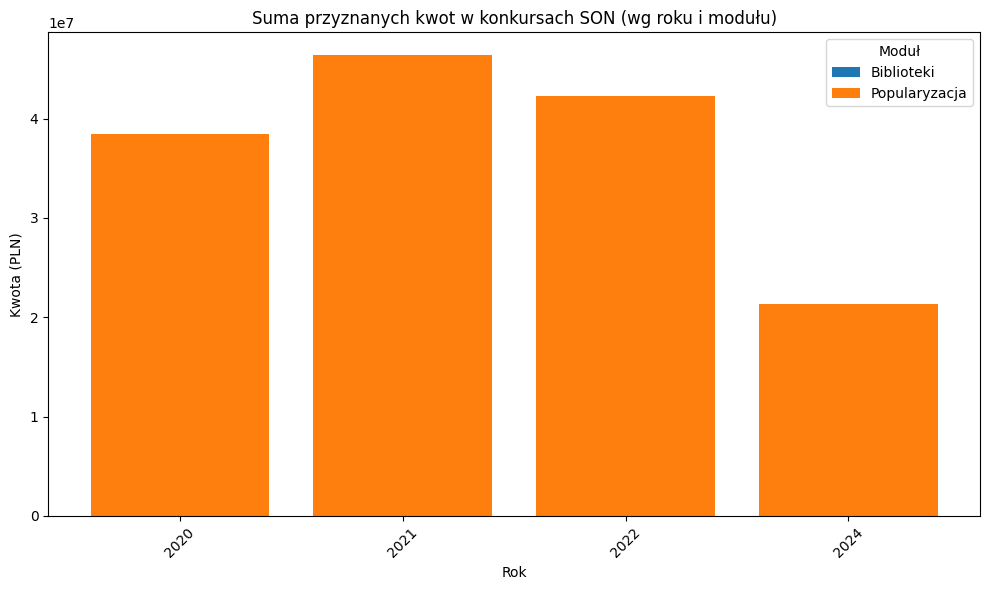

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for modul, sub in df_sum.groupby("Moduł"):
    plt.bar(sub["Rok"].astype(str), sub["Kwota_clean"], label=modul)

plt.title("Suma przyznanych kwot w konkursach SON (wg roku i modułu)")
plt.xlabel("Rok")
plt.ylabel("Kwota (PLN)")
plt.legend(title="Moduł")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


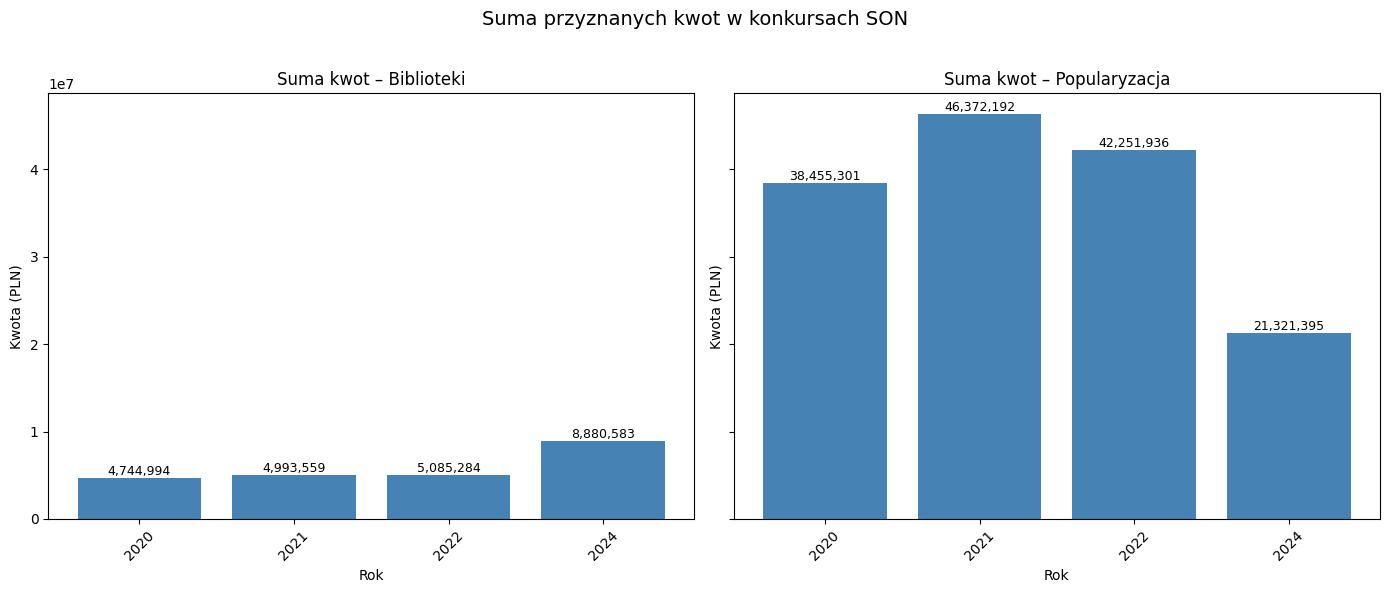

In [10]:
import matplotlib.pyplot as plt

# Upewnij się, że df_sum istnieje
if "df_sum" not in locals():
    raise NameError("Najpierw uruchom komórki 4–6, by utworzyć df_sum")

# Lista modułów (np. "Popularyzacja", "Biblioteki")
moduly = df_sum["Moduł"].unique()

# Ustawienia wykresów obok siebie
fig, axes = plt.subplots(1, len(moduly), figsize=(14, 6), sharey=True)

if len(moduly) == 1:
    axes = [axes]  # obsługa przypadku z jednym modułem

for ax, modul in zip(axes, moduly):
    sub = df_sum[df_sum["Moduł"] == modul]
    ax.bar(sub["Rok"].astype(str), sub["Kwota_clean"], color="steelblue")
    ax.set_title(f"Suma kwot – {modul}")
    ax.set_xlabel("Rok")
    ax.set_ylabel("Kwota (PLN)")
    ax.tick_params(axis="x", rotation=45)
    # Dodaj wartości na słupkach
    for i, val in enumerate(sub["Kwota_clean"]):
        ax.text(i, val, f"{val:,.0f}", ha="center", va="bottom", fontsize=9)

plt.suptitle("Suma przyznanych kwot w konkursach SON", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
